In [51]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [52]:
from sklearn.linear_model import LogisticRegression

In [53]:
import pandas as pd 

train_data = pd.read_csv('C:/Users/natal/Downloads/train.csv', sep=',')

In [56]:
train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [57]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [20]:
pd.set_option("display.max_rows", None)

In [21]:
train_data["Parch"].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [22]:

train = train_data.drop(['PassengerId', 'Ticket'], axis=1)


In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB


In [24]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CabinTransformer(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        # funcka mapująca np. np.map
        #apply function to NumPy array
        output = np.array([[word[0][0],word[0][1] if len(word[0])>1 else "1"]  for word in X])
        return output.reshape(-1, 2)
        

In [25]:
train['Family'] = train.SibSp + train.Parch


In [26]:
family=train.groupby('Family')['Survived'].sum().reset_index()
family

,Family,Survived
0,0,163
1,1,89
2,2,59
3,3,21
4,4,3
5,5,3
6,6,4
7,7,0
8,10,0


In [27]:
train['TravelAlone']=np.where((train["SibSp"]+train["Parch"])>0, 0, 1)
#train['TravelAlone']

In [28]:
train_title = [i.split(",")[1].split(".")[0].strip() for i in train["Name"]]
train["Title"] = pd.Series(train_title)
train["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [29]:
train["Title"] = train["Title"].map({"Mrs":"Married", "Miss":"Single", "Mr" : "Unknown"})

In [30]:
train["Title"].head()

0    Unknown
1    Married
2     Single
3    Married
4    Unknown
Name: Title, dtype: object

In [31]:
numeric_features = ['Age', 'Fare','Family']
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['Embarked', 'Sex', 'Pclass','TravelAlone',"Title"]#, 'SibSp', 'Parch']
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

cabin_feature = ['Cabin']
cabin_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value="Missing")),
                                          ('pierwsza_litera', CabinTransformer()),# wlasny transformer
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
        ('cabin',cabin_transformer, cabin_feature ),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [32]:
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Cabin', 'Embarked', 'Family', 'TravelAlone', 'Title'],
      dtype='object')

In [33]:
X_train = preprocessor.fit_transform(train.drop(["Survived"],axis=1))
y_train= train["Survived"]

In [34]:
model =  LogisticRegression()


In [ ]:
model.fit(X_train, y_train)

In [36]:
model.score(X_train, y_train)

0.8294051627384961

In [37]:
train_data.loc[(train_data["Parch"] >=2), 'Parch'] = 2

In [38]:
train_data["Parch"].value_counts()

0    678
1    118
2     95
Name: Parch, dtype: int64

In [40]:
def age_group(age):
    if age >= 80:
        return '80-89'
    if age >= 70:
        return '70-79'
    if age >= 60:
        return '60-69'
    if age >= 50:
        return '50-59'
    if age >= 40:
        return '40-49'
    if age >= 30:
        return '30-39'
    if age >= 20:
        return '20-29'
    if age >= 10:
        return '10-19'
    if age >= 0:
        return '0-9'
    
train_data['AgeGroup'] = train_data.Age.apply(age_group)
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TravelAlone,AgeGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,20-29
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,30-39
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,20-29
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,30-39
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,30-39


In [41]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

Logistic Regression:

In [42]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

acc_log = round(logreg.score(X_train, y_train) * 100, 2)

 Decision Tree:



In [47]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train) 
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)

In [48]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

predictions = cross_val_predict(decision_tree, X_train, y_train, cv=3) #decisiontree
confusion_matrix(y_train, predictions)

array([[438, 111],
       [113, 229]], dtype=int64)

The first row relates to the "did not survive" predictions: 441 passengers were correctly classified as non-survivors (so-called true negatives), and 101 where misclassified as non-survivors (false positives).

The second row relates to survival predictions:111 passengers were misclassified as survivors (so-called false negatives), and 231 were correctly classified as survivors (so-called true positives).

In [43]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

predictions = cross_val_predict(logreg, X_train, y_train, cv=3)
confusion_matrix(y_train, predictions) #Logistic Regression

array([[468,  81],
       [ 87, 255]], dtype=int64)

Each row in the confusion matrix represents an actual class, while each column represents a predicted class.

The first row relates to the "did not survive" predictions: 468 passengers were correctly classified as not surviving (so-called true negatives), and 81 where misclassified as not surviving (false positives).

The second row is for survival predictions: 87 passengers were misclassified as survivors (so-called false negatives), and 255 were correctly classified as survivors (so-called true positives).



Precision and Recall:

In [ ]:
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(y_train, predictions))
print("Recall:",recall_score(y_train, predictions)) #decisiontree

Precision: 0.6814159292035398
Recall: 0.6754385964912281


Our model predicts 68% of the time, the survival of passengers correctly (precision). Recall tells us that it predicted the survival of 68% of those who actually survived.

In [ ]:

from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(y_train, predictions))
print("Recall:",recall_score(y_train, predictions)) #Logistic Regression

Precision: 0.7589285714285714
Recall: 0.7456140350877193


Our model predicts 76% of the time, the survival of passengers correctly (precision). Recall tells us that it predicted the survival of 75% of those who actually survived.

We can combine precision and recall into one score, which is called the F-score. The F-score is computed with the harmonic mean of precision and recall.

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train, predictions) #decision tree

0.6784140969162995


 68% F-score. 



In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train, predictions) #Logistic Regression

0.7522123893805309

We have this, a 75% F-score. The score is not that high because we have a recall of 75%. The closer it is to one, the better it indicates the classification algorithm. At best, it takes a value of 1, when we have perfect sensitivity and precision.  As a result
the classifier will get a high F score only when both recall and precision are high.


Precision Recall Curve

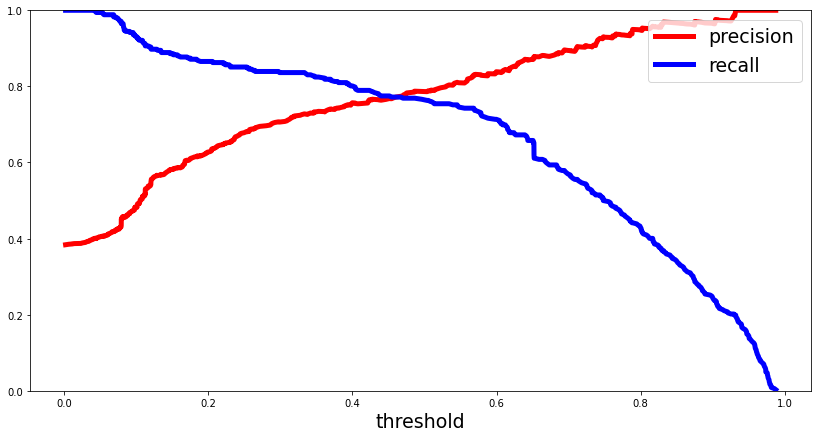

In [45]:
from sklearn.metrics import precision_recall_curve  #Logistic Regression
import matplotlib.pyplot as plt


# getting the probabilities of our predictions  #Logistic Regression
y_scores = logreg.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(y_train, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

Recall drops sharply at a precision of about 75%. For this reason, you may want to choose a precision/recall tradeoff earlier - perhaps at around 65%.

For decisiontree:

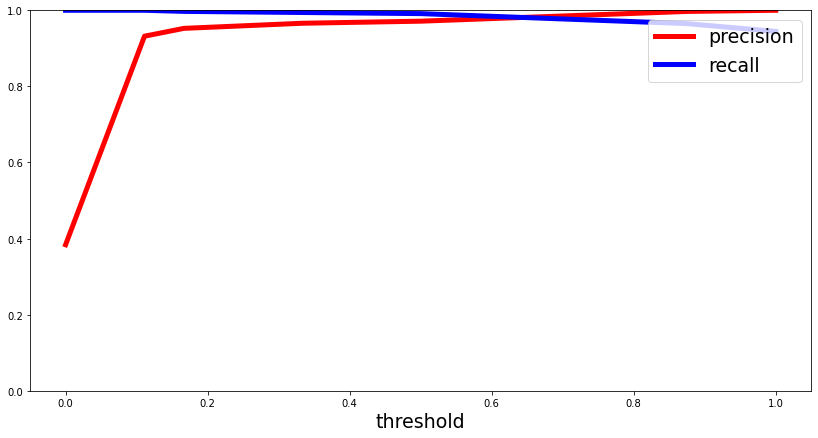

In [49]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


# getting the probabilities of our predictions  #decisiontree
y_scores = decision_tree.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(y_train, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

Calculation of precision and recall for all possible thresholds:

In [ ]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

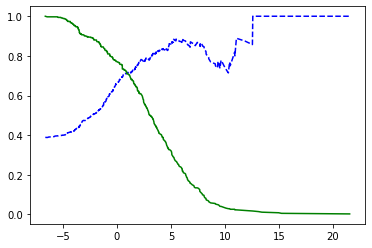

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()



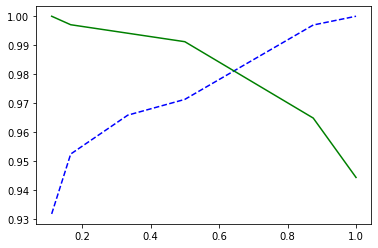

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
#decisiontree

Precision can sometimes drop as you raise the threshold.

Another way to choose a good compromise between precision and recall is to plot precision
directly against recall.

The ROC Curve

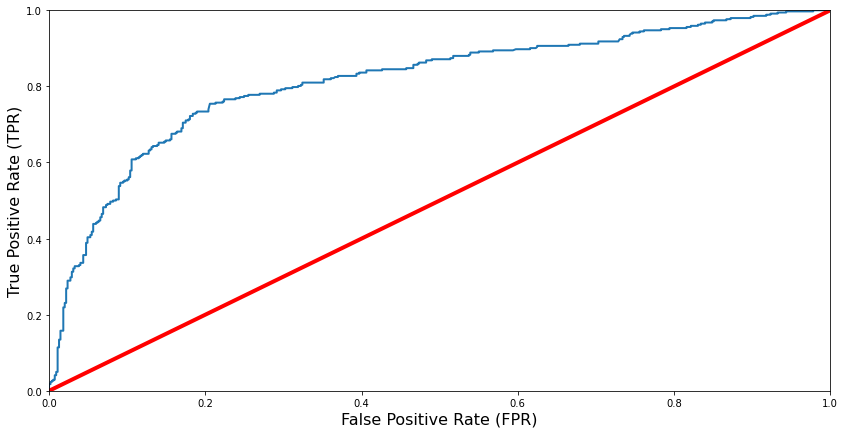

In [ ]:
from sklearn.metrics import roc_curve  #Logistic Regression
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_scores)
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

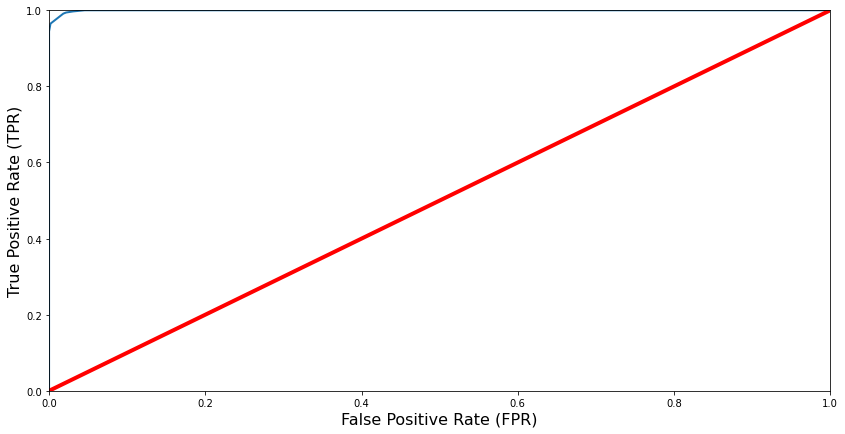

In [50]:
#Decision treee
from sklearn.metrics import roc_curve
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_scores)
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

Since the ROC curve is so similar to the precision/recall (PR) curve, one may wonder
how to decide which one to use. As a rule of thumb, the PR curve should be preferred
when the positive class is rare or when you care more about false positives than
than false negatives. Otherwise, use the ROC curve. For example, looking at the previous
ROC curve (and the ROC AUC result), you might think that the classifier is really good.

ROC AUC Score


In [46]:
from sklearn.metrics import roc_auc_score
r_a_score = roc_auc_score(y_train, y_scores)
print("ROC-AUC-Score:", r_a_score)   #Logistic Regression

ROC-AUC-Score: 0.8776696598813367


In [ ]:
from sklearn.metrics import roc_auc_score
r_a_score = roc_auc_score(y_train, y_scores)
print("ROC-AUC-Score:", r_a_score)  #decisiontree

ROC-AUC-Score: 0.9994700625272958
